# Normal Model with 2D GP Priors and Synthetic Data

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import pandas as pd
import torch
from utils import generate_data, match

from famo.core import CORE

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Generation

In [2]:
data = generate_data(
    n_samples={"group_1": 400, "group_2": 350},
    n_features={"view_1": 200, "view_2": 250},
    n_factors=3,
    likelihoods={"view_1" : "Normal", "view_2" : "Normal"},
    covariates={"group_1" : torch.rand(400, 2), "group_2" : torch.rand(350, 2)},
    factor_smoothness={"group_1" : [0.01, 0.5, 0.99], "group_2" : [0.99, 0.01, 0.01]}
)

/data/ilia/envs/pytorch2/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/data/ilia/envs/pytorch2/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [3]:
model = CORE(device="cuda")
model.fit(
    n_factors=3,
    data=data,
    factor_prior="GP",
    weight_prior="Normal",
    covariates_obsm_key="x",
    lr=0.005,
    early_stopper_patience=500,
    print_every=500,
    center_groups=True,
    scale_views=False,
    scale_groups=True,
    max_epochs=10000,
    init_factors="random",
    init_scale=0.1,
    save=False,
)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
- No likelihoods provided. Inferring likelihoods from data.
  - view_1: Normal
  - view_2: Normal


alt.Chart(...)

alt.Chart(...)

Initializing factors using `random` method...
Decaying learning rate over 10000 iterations.
Setting training seed to `2410111332`.
Cleaning parameter store.


/data/ilia/envs/pytorch2/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/data/ilia/envs/pytorch2/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


2024-10-11 13:32:30,858 - root - INFO - Guessed max_plate_nesting = 3
Epoch:       0 | Time:       1.52s | Loss:     584.77
Epoch:     500 | Time:      18.00s | Loss:     323.58
Epoch:    1000 | Time:      34.57s | Loss:     298.51
Epoch:    1500 | Time:      50.68s | Loss:     297.89
Training finished after 1946 steps.


## Assignment of Inferred to True Factors

In [4]:
group = "group_1"
view = "view_1"

w = model.get_weights("pandas")[view]
z = model.get_factors("pandas")[group]

w_gt = pd.DataFrame(data[group][view].varm["w"].T, columns=data[group][view].var_names)
z_gt = pd.DataFrame(data[group][view].obsm["z"], index=data[group][view].obs_names)
x = pd.DataFrame(
    data[group][view].obsm["x"], index=data[group][view].obs_names
).sort_index(axis=0)

z_common_indices = z.index.intersection(z_gt.index)
z = z.loc[z_common_indices].sort_index(axis=0)
z_gt = z_gt.loc[z_common_indices].sort_index(axis=0)

w_common_cols = w.columns.intersection(w_gt.columns)
w = w.loc[:, w_common_cols].sort_index(axis=1)
w_gt = w_gt.loc[:, w_common_cols].sort_index(axis=1)

inds, signs = match(z_gt.values, z.values, dim=-1)

z = z.iloc[:, inds] * signs
w = w.iloc[inds] * signs.reshape(-1, 1)

## Correlation Plots

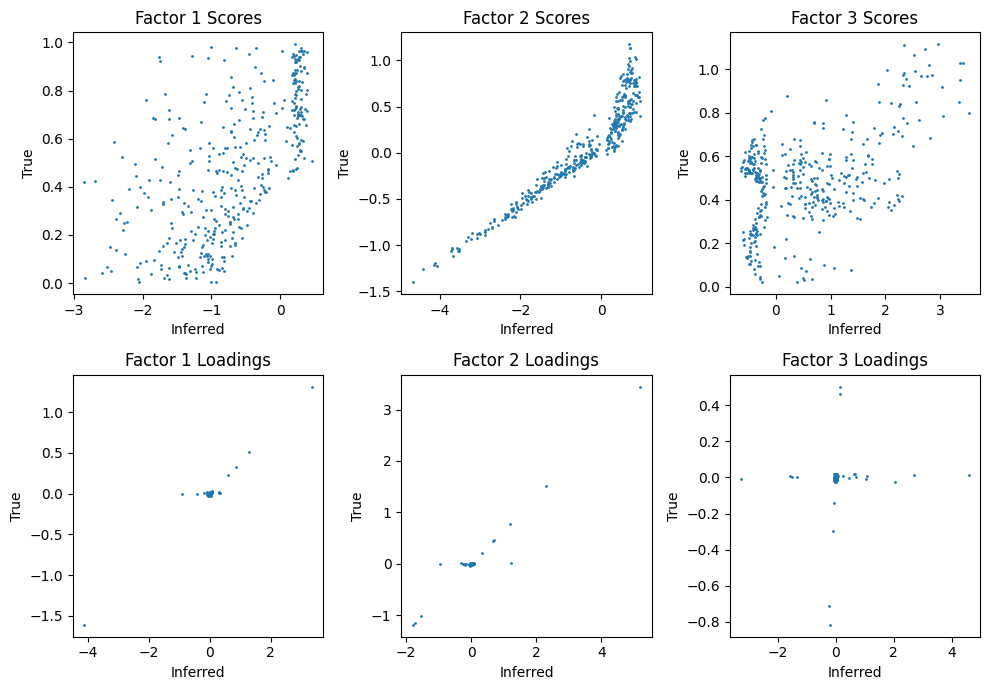

In [5]:
fig, axs = plt.subplots(2, z.shape[1], figsize=(10, 7))
for i in range(z.shape[1]):
    axs[0, i].scatter(z.iloc[:, i], z_gt.iloc[:, i], s=1)
    axs[1, i].scatter(w.iloc[i], w_gt.iloc[i], s=1)
    axs[0, i].set_title(f"Factor {i + 1} Scores")
    axs[1, i].set_title(f"Factor {i + 1} Loadings")

for ax in axs.flatten():
    ax.set_xlabel("Inferred")
    ax.set_ylabel("True")

plt.tight_layout()

## Factor - Covariate Plots

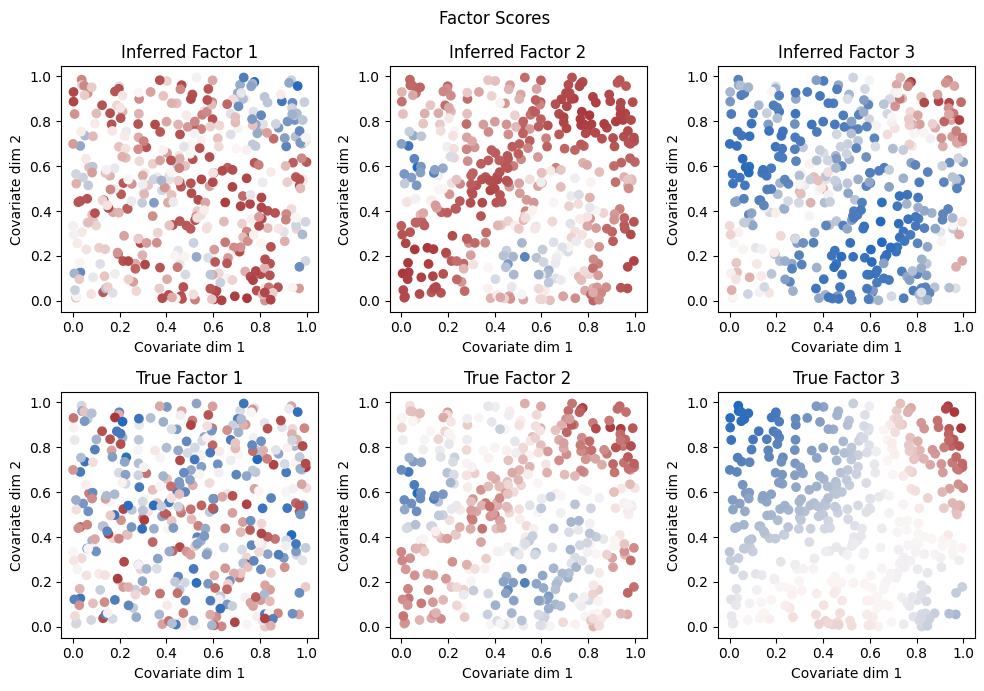

In [6]:
fig, axs = plt.subplots(2, z.shape[1], figsize=(10, 7))

for i in range(z.shape[1]):
    axs[0, i].scatter(x.iloc[:, 0], x.iloc[:, 1], c=z.iloc[:, i], cmap="vlag")
    axs[0, i].set_xlabel("Covariate dim 1")
    axs[0, i].set_ylabel("Covariate dim 2")
    axs[0, i].set_title(f"Inferred Factor {i+1}")

    axs[1, i].scatter(x.iloc[:, 0], x.iloc[:, 1], c=z_gt.iloc[:, i], cmap="vlag")
    axs[1, i].set_xlabel("Covariate dim 1")
    axs[1, i].set_ylabel("Covariate dim 2")
    axs[1, i].set_title(f"True Factor {i+1}")

plt.suptitle("Factor Scores")
plt.tight_layout()